Abstract: Even though that window-opening behavior strongly influences heat demand and indoor air quality in district-heated appartments, it is rarely or never observed directly. In research behinf this paper, we develop an initial approach for window-opening event detection, by using a fully unsupervised detection pipeline that infers ventilation episodes from telemetry at 3-minute resolution (indoor temperature, CO₂, relative humidity, outdoor temperature, and heating context). When compared with similar works, the approach brings innovation in physics-informed feature engineering and in using method-agnostic heuristics for transforming point anomalies, detected by two methodologicaly different multivariate anomaly detection approaches - Isolation Forest and a bottleneck Autoencoder, to ventillation episodes. Applied to a full heating season, both models detect a consistent diurnal signature: a dominant late-morning concentration (≈09:00–12:00) and a smaller evening band (≈19:00–22:00), with few overnight detections. Isolation Forest consolidated 506 point anomalies into 100 events; the Autoencoder yielded 764 points and 82 events; their intersection produced 46 high-confidence events from 303 jointly flagged points, indicating robustness across modeling assumptions while trading recall for precision. The results show that standard heat supply and demand signals are sufficient to reliably uncoverventilation episodes without door/window sensors, enabling demand-aware operation and occupant feedback.

# Introduction

Understanding consumer behavior is essential for optimizing operation of the District Heating System (DHS), as it has substantial impact on the heating efficiency and effectiveness. Considering some of the behavioral patterns could help to significantly improve the efficiency of the DHS, e.g. occupancy, ventilation periods, thermostat adjustment, peaks in hot water consumption, wake-up and sleep schedule, etc. 

Great most of the legacy DHS operate by using supply-driven control logic, where this logic is implemented in a semi-automatic manner. The delivery of heat at the level of substations is automatic, and it is driven by using so-called control curve, which describes the targeted dependency of temperature of heating fluid in primary and secondary supply flows (from plant to substations and substations to consumers, respectively) and ambient temperature. However, set points of the control curve are defined manually by the plant operators, who consider fixed heating schedules and weather-based predictions.

This approach to operating DHS is inefficient. For example, it does not involve demand-side awareness, including comfort level of apartments and consumer behavioral patterns. DHS has no awareness whether occupants are home, whether some rooms in the apartments are actually used or, for example, whether windows are open. Thus, great losses are expected in situations such as night hours in unoccupied rooms, ventilation periods (windows open) and long-term vacancies (travel, holidays). Detecting the abovementioned and other consumer behavior patterns would improve demand forecasting accuracy, by introducing novel highly relevant model features, and thus achieve better energy efficiency but also much higher service quality, due to reduced over- and under-heating effects.

Researchers today approach window opening detection through direct sensing, statistical methods and advanced data-driven models, with use of modern supervised or unsupervised Machine Learning approaches.

The direct sensing methods are the most successful, but they require fitting special sensor infrastructure, which is not cost-effective, and sometimes it introduce privacy concerns. Visual sensing, for example, by using security cameras, is one approach that researchers dealt with in the past. Use of convolutional neural networks (CNN), such as Faster R-CNN and object detection algorithms, such as YOLOv3/4/5, enabled detection of window opening based on visual data. These applications are suitable for real-time uses and HVAC systems integration (Tien et al., 2022). Visual models not only detect the window state (open/closed), but can also estimate the degree of window opening, which can be important for ventilation control (Liu et al., 2023). In the paper (Sun et al., 2022), similar approaches have been applied in specific climatic conditions with an accuracy of almost 98%. In the same manner, it is also possible to monitor the opening of doors and windows, which can further influence the prediction of future consumption (Sezen et al., 2022). These methods, while addressing the issue of costly additional infrastructure are still highly intrusive and cannot be effectively applied in large number of consumers.

Statistical methods can be classified among the oldest types of window-opening event detection. Most of them are based on the identification of sudden changes in time series of measured parameters. Change Point Analysis (CPA) and variants such as the AMOC, BinSeg, and SAP methods have found application in the detection of user activity in buildings, including window opening, using measurements of temperature, relative humidity, and CO₂ concentration (Aminikhanghahi et al., 2019). These approaches have shown high accuracy (up to 97% for opening windows), but they are primarily applied in offline analysis (Pereira & Ramos, 2018). Some studies use internal parameters of the environment (temperature, CO2, and relative humidity), smoothing and change detection techniques to isolate sudden changes in data sequences when opening windows. These methods are often better than supervised models but require manual parameter tuning and are not intended for real-time applications (Ume-Ezeoke et al., 2024). For larger and complex data sets with real and simulated data, more advanced statistical approaches like multivariate Gaussian CPD and other dimensionality reduction methods (PCA, autoencoders) are used.

Machine Learning (ML) methods are today often used to detect window opening events. Supervised ML algorithms require ground truth data, namely the timestamps of window opening and closing events and a dataset with appropriate set of features. They involve the application of regression models and classification algorithms such as Random Forest (RF), K-Nearest Neighbour (KNN), Artificial Neural Network (ANN), Bayesian Network Classification, Logistical regression, and Regression Tree (CART) (Barthelmes et al., 2017; Park et al., 2021). More advanced algorithms like XGBoost have shown better accuracy compared to classical regression models, especially when using combined data sets from sensors (Mo et al., 2019). Combining multiple data sources and custom algorithms enabled high accuracy, such as for seasonal variations and specific weather conditions (de Rautlin de la Roy et al., 2023). Despite this, it must be emphasized that the results vary depending on transformations and selected features. Hybrid models combine the advantages of statistical methods and ML algorithms. One of the examples is a combination of statistical components with XGBoost or LightGBM algorithms to model user behavior, using a wide range of input data (Liu et al., 2024).

While the accuracy of supervised models is normally very high, the need for a data collection experiment per each consumer to acquire ground truth data make them impractical. Although supervised models perform best under control conditions, semi-supervised approaches offer a trade-off between accuracy and real-time applicability (Jiang et al., 2022). 

Both supervised and unsupervised models use extensive feature engineering for the effective representation of the conditions which are relevant for classifying (supervised ML) or detecting (unsupervised ML) window opening event. The literature review shows that all features used for the implementation of ML algorithms can be classified into four categories (Aminikhanghahi et al., 2019; Barthelmes et al., 2017; Park et al., 2021): 

- Timing features - day of week, hour of day, minutes of hour;
- Window features - sensor status (open or closed state of window), count of events for each sensor in window, elapsed time for each sensor since last event, most recent sensor in window, first sensor in window, window duration and similar;
- Outdoor environment features - Outdoor temperature, solar radiation, wind speed, etc.;
- Indoor environment features - Air temperature, relative humidity and CO2 concentration.

In the literature, the indoor CO2 concentration, relative humidity, and the outdoor temperature were found as the most important variables in determining the state of window-opening events when using statistical and ML algorithms (Andersen et al., 2013; Barthelmes et al., 2017; Park et al., 2021; Pereira et al., 2018; Yao & Zhao, 2017).

This paper is result of work, which is a part of larger research (Zdravković et al, 2024) aiming at enabling the data-driven (Cvetković et al, 2025) intelligent control of DHS by using the capabilities of modern explainable ML methods, applied for interpretable forecasting of heat demand and thermal comfort (at supply and demand side), detection of consumer behavior and other operation properties of the system (for example, thermal inertia), including its abnormal behavior (Turudija et al, 2024). The window opening event detection method relies on using modern unsupervised ML methods for multivariate outlier detection, based on the extensive feature engineering of supply and demand data, acquired from the local DHS (including control parameters and delivered heat) and with multiple consumers (CO2, humidity and indoor temperature data), in 3 minutes resolution. We test two of the most advanced methods, namely Isolation Forest and Autoencoder neural network. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import zscore


from scipy.signal import argrelextrema
from collections import Counter
from sklearn.covariance import MinCovDet

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPRegressor


from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

import requests
import zipfile
import io
import warnings

import os
import shutil

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


season_start='2024-11-17 06:00:00'
season_end='2025-04-01 00:00:00'

# Implementation

The research is using supply and demand data of one heating season (for selected consumer) acquired from a local DHS, in period of 2024-11-17 to 2025-04-01 with 3min resolution, namely 64477 data points. The dataset is pre-processed by using a raw data openly published at GitHub repository (https://github.com/xai4heat/xai4heat). Besides merging supply and demand data, missing time points are imputed by using linear interpolation, which is considered a sufficiently good approximation for dense time series data and corresponding physical nature of the data.

In [140]:
# Download the zip file from GitHub
url_scada = "https://github.com/xai4heat/xai4heat/raw/main/datasets/scada_data_2024-25.zip"
url_thermionyx = "https://github.com/xai4heat/xai4heat/raw/main/datasets/thermionyx_data_2024-25_1min.zip"

response_scada = requests.get(url_scada)
response_thermionyx = requests.get(url_thermionyx)

with zipfile.ZipFile(io.BytesIO(response_scada.content)) as z:
    csv_files = [f for f in z.namelist() if f.endswith('.csv')]
    with z.open(csv_files[0]) as f:
        dfs = pd.read_csv(f)

with zipfile.ZipFile(io.BytesIO(response_thermionyx.content)) as z:
    csv_files = [f for f in z.namelist() if f.endswith('.csv')]
    with z.open(csv_files[0]) as f:
        dft = pd.read_csv(f)


# Processing Thermionyx data

dft['datetime'] = pd.to_datetime(dft['datetime'])
dft.set_index('datetime', inplace=True)
dft.sort_index(inplace=True)

dft['sensor_co2'] = dft['name'].str.endswith('_CO2')
name_parts = dft['name'].str.replace('_CO2$', '', regex=True).str.split('_', expand=True)
dft['block_name'] = name_parts[0]
dft['building_number'] = name_parts[1]
dft['apartment_number'] = name_parts[2]

dft.drop(columns=['probe_id', 'name'], inplace=True)



# Filter dft for block_name 'L4' and apartment_number '12'
dft_4 = dft[(dft['block_name'] == 'L4') & (dft['apartment_number'] == '12') & (dft['sensor_co2'] == True)].copy()[['temperature', 'relative_humidity', 'co2']]
dft_4 = dft_4.resample('3min').first().dropna(how='all')
#dft_4.head(20)




dfs_4=dfs[(dfs['location'] == 'TPS Lamela L4')].copy()[['datetime', 'e', 't_amb']]

dfs_4['datetime'] = pd.to_datetime(dfs_4['datetime'])
dfs_4['e'] = dfs_4['e'].replace(0, np.nan)
dfs_4['e']=dfs_4['e'].interpolate(method='linear')
dfs_4.set_index('datetime', inplace=True)
dfs_4 = dfs_4[~dfs_4.index.duplicated(keep='first')]
dfs_4 = dfs_4.resample('3min').first().dropna(how='all')
dfs_4.sort_index(inplace=True)

dfs_4['qizm']=(dfs_4['e']-dfs_4['e'].shift(1))*1000
dfs_4['qizm'] = dfs_4['qizm'].apply(lambda x: 0 if x <= 31 else x)

#Replacing outliers with linearly interpolated values
zs = zscore(dfs_4['qizm'])
dfs_4.loc[np.abs(zs) > 4, 'qizm'] = np.nan
dfs_4['qizm'] = dfs_4['qizm'].interpolate(method='linear')

date_range_season = (dfs_4.index >= pd.to_datetime(season_start)) & (dfs_4.index < pd.to_datetime(season_end))
dfs_4 = dfs_4[date_range_season].copy()
dfs_4.drop(columns=['e'], inplace=True)
dfs_4["qin"] = dfs_4["qizm"] / (3/60)
#dfs_4.head(20)

dftc = pd.merge(dfs_4, dft_4, left_index=True, right_index=True, how='left')
dftc.rename(columns={'temperature': 'rtemp_4',
                     'relative_humidity': 'rhumid_4',
                     'co2': 'rco2_4',
                     }, inplace=True)



# Interpolate NaNs for room temperatures and key temperature signals
interp_cols = dftc.columns
for col in interp_cols:
    if col in dftc.columns:
        dftc[col] = pd.to_numeric(dftc[col], errors="coerce")  # force numeric
        dftc[col] = dftc[col].interpolate(method='time')       # time-based interpolation

# Optionally fill any remaining NaNs at the edges with nearest valid
dftc[interp_cols] = dftc[interp_cols].fillna(method='bfill').fillna(method='ffill')



dftc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64477 entries, 2024-11-17 06:00:00 to 2025-03-31 23:57:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   t_amb     64477 non-null  float64
 1   qizm      64477 non-null  float64
 2   qin       64477 non-null  float64
 3   rtemp_4   64477 non-null  float64
 4   rhumid_4  64477 non-null  float64
 5   rco2_4    64477 non-null  float64
dtypes: float64(6)
memory usage: 3.4 MB


C:\Users\Milan\AppData\Local\Temp\ipykernel_41452\2284807312.py:83: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dftc[interp_cols] = dftc[interp_cols].fillna(method='bfill').fillna(method='ffill')


The figure below presents a visualization of key environmental and heating signals for a representative apartment over a selected day (2024-12-31), with both raw and smoothed time series shown for each variable, by using Savitzky-Golay filter. Plot displays the incremental heat input to the apartment (qizm, in kWh, green line), indoor air temperature (rtemp_4, red), indoor CO₂ concentration (rco2_4, blue), and outdoor air temperature (t_amb, gray). 

Apparent small variability of indoor sensing data implies sensor bias, which will be dealt with in the pre-processing by smoothening.

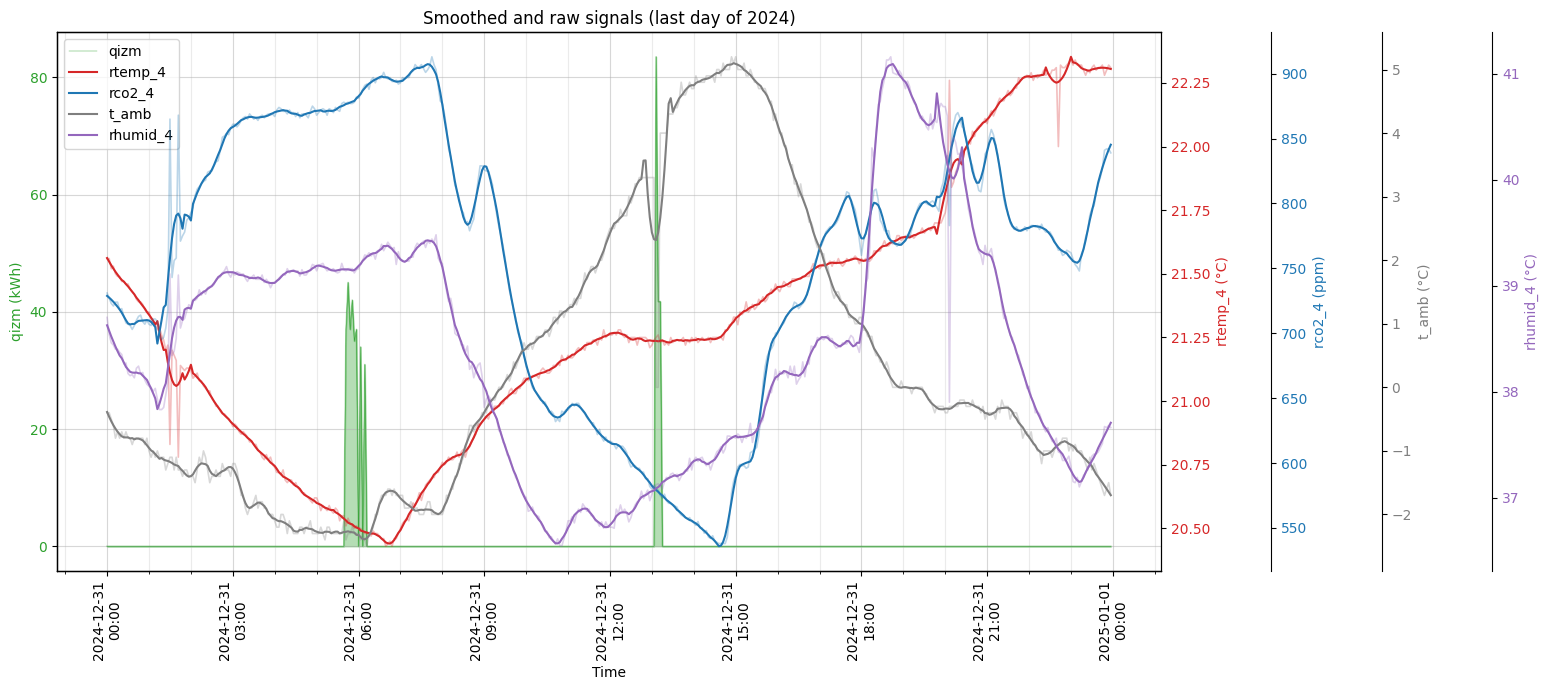

In [148]:
from scipy.signal import savgol_filter

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==== PARAMETERS ====
# Set the period for plotting (can be changed later)
plot_start = "2024-12-31"
plot_end   = "2024-12-31"

# Smoothing parameters
window_length = 6  # must be odd and >= polyorder+2
polyorder = 2

# ==== DATA SELECTION ====
df_plot = dftc.loc[plot_start:plot_end].copy()

# Apply Savitzky-Golay smoothing to each signal
def smooth(series, window_length=12, polyorder=2):
    n = len(series)
    win = min(window_length, n if n % 2 == 1 else n-1)
    if win < polyorder + 2:
        win = polyorder + 3
    if win % 2 == 0:
        win += 1
    if n < win:
        return series  # not enough data to smooth
    return pd.Series(savgol_filter(series, window_length=win, polyorder=polyorder), index=series.index)

signals = {
    "qizm": df_plot["qizm"],
    "rtemp_4": df_plot["rtemp_4"],
    "rhumid_4": df_plot["rhumid_4"],
    "rco2_4": df_plot["rco2_4"],
    "t_amb": df_plot["t_amb"]
}

smoothed = {k: smooth(v) for k, v in signals.items()}

# ==== PLOTTING ====
fig, ax_qin = plt.subplots(figsize=(16, 7))

# Primary axis: qin
h_qin, = ax_qin.plot(signals["qizm"].index, signals["qizm"], color="tab:green", label="qizm (primary)", linewidth=0.3)
# Overlay original qizm (same as above, but more transparent)
ax_qin.plot(signals["qizm"].index, signals["qizm"], color="tab:green", alpha=0.3, linewidth=1.2, label="qizm (orig)")

ax_qin.set_ylabel("qizm (kWh)", color="tab:green")
ax_qin.tick_params(axis='y', labelcolor="tab:green")

# Secondary axes
ax_temp = ax_qin.twinx()
h_temp, = ax_temp.plot(smoothed["rtemp_4"].index, smoothed["rtemp_4"], color="tab:red", label="rtemp_4")
# Overlay original rtemp_4
ax_temp.plot(signals["rtemp_4"].index, signals["rtemp_4"], color="tab:red", alpha=0.3, linewidth=1.2, label="rtemp_4 (orig)")
ax_temp.set_ylabel("rtemp_4 (°C)", color="tab:red")
ax_temp.tick_params(axis='y', labelcolor="tab:red")

ax_co2 = ax_qin.twinx()
ax_co2.spines["right"].set_position(("axes", 1.10))
h_co2, = ax_co2.plot(smoothed["rco2_4"].index, smoothed["rco2_4"], color="tab:blue", label="rco2_4")
# Overlay original rco2_4
ax_co2.plot(signals["rco2_4"].index, signals["rco2_4"], color="tab:blue", alpha=0.3, linewidth=1.2, label="rco2_4 (orig)")
ax_co2.set_ylabel("rco2_4 (ppm)", color="tab:blue")
ax_co2.tick_params(axis='y', labelcolor="tab:blue")

ax_tamb = ax_qin.twinx()
ax_tamb.spines["right"].set_position(("axes", 1.20))
h_tamb, = ax_tamb.plot(smoothed["t_amb"].index, smoothed["t_amb"], color="tab:gray", label="t_amb")
# Overlay original t_amb
ax_tamb.plot(signals["t_amb"].index, signals["t_amb"], color="tab:gray", alpha=0.3, linewidth=1.2, label="t_amb (orig)")
ax_tamb.set_ylabel("t_amb (°C)", color="tab:gray")
ax_tamb.tick_params(axis='y', labelcolor="tab:gray")

ax_hum = ax_qin.twinx()
ax_hum.spines["right"].set_position(("axes", 1.30))
h_hum, = ax_hum.plot(smoothed["rhumid_4"].index, smoothed["rhumid_4"], color="tab:purple", label="rhumid_4")
# Overlay original rhumid_4
ax_hum.plot(signals["rhumid_4"].index, signals["rhumid_4"], color="tab:purple", alpha=0.3, linewidth=1.2, label="rhumid_4 (orig)")
ax_hum.set_ylabel("rhumid_4 (°C)", color="tab:purple")
ax_hum.tick_params(axis='y', labelcolor="tab:purple")

# Grid, legend, and cosmetics
ax_qin.grid(True, which='both', axis='both', alpha=0.5)
ax_qin.set_xlabel("Time")
ax_qin.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
plt.setp(ax_qin.get_xticklabels(), rotation=90)

# Add secondary grid with one hour resolution
ax_qin.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax_qin.grid(True, which='minor', axis='x', alpha=0.25)

# --- Shade area below qizm in transparent green ---
ax_qin.fill_between(signals["qizm"].index, 0, signals["qizm"], color="tab:green", alpha=0.35, zorder=0)

# Build legend (show only main lines)
lines = [h_qin, h_temp, h_co2, h_tamb, h_hum]
labels = ["qizm", "rtemp_4", "rco2_4", "t_amb", "rhumid_4"]
ax_qin.legend(lines, labels, loc="upper left")

plt.title(f"Smoothed and raw signals (last day of 2024)")
plt.tight_layout()
plt.show()

## Feature engineering

For the purpose of multi-variate outlier detection on the available dataset for apartment 4 with 3-min sampling, the extensive feature engineering process has been carried out. The features include different statistical features (difference and variability) of the indoor thermal response (temperature features), ventilation/dillution signature (CO<sub>2</sub> features), humidity features and heating/plant context features.  

Let x<sub>t</sub> denote a variable at time index t. For a horizon of k steps, a finite difference is Δ<sub>k</sub> x<sub>t</sub> = x<sub>t</sub> - x<sub>t-k</sub>, and the rolling variability σ<sub>k</sub>(x)t = std{x<sub>t-k+1</sub>,...,x<sub>t</sub>}.
We use indoor room-4 signals T<sub>t</sub>=rtemp_4, H<sub>t</sub>=rhumid_4, C<sub>t</sub>=rco2_4, outdoor temperature T<sup>amb</sup><sub>t</sub>=t_amb, and heating/plant context (qin).

We compute features at horizons k∈{1,2,3}, corresponding to 3, 6 and 9 minutes. Window opening typically induces: 

1. abrupt indoor temperature decrease due to infiltration, 
2. CO<sub>2</sub> decrease via dilution when indoor levels exceed outdoor background, 
3. short-term volatility ('turbulence') in both T and C, and 
4. temporal persistence over several samples. The feature set captures these signatures while controlling for confounding from outdoor conditions and heating transients.

Temperature features (indoor thermal response) are:

- Instantaneous and multi-horizon temperature drops: Δ<sub>1</sub> T<sub>t</sub> (3 min), Δ<sub>2</sub> T<sub>t</sub> (6 min), Δ<sub>3</sub> T<sub>t</sub> (9 min). Window opening produces a rapid conductive/convective loss and thus negative increments at short horizons, while the 8–9 min differences capture sustained cooling beyond sensor noise and controller dithering.

- Short-term temperature variability: σ<sub>2</sub>(T)<sub>t</sub> (6 min), σ<sub>3</sub>(T)<sub>t</sub> (9 min).
Rationale: Infiltration increases short-horizon variance (gusts, drafts, mixing). Rolling standard deviation is a robust turbulence proxy that complements mean-shift features. When a window is opened, the indoor air is suddenly coupled to the outdoors. The exchange is intermittent, driven by wind gusts, pressure changes (stack effect), and micro-currents near the opening. That makes the signals (T, CO2, sometimes humidity) jagged over short timescales: instead of a smooth monotonic drop, you see small up/down pulses. HVAC changes, in contrast, usually look smoother at the same timescale. So volatility features aim to quantify how "wiggly" the signal is over a short window. They complement mean-shift features (like ΔT over 6–9 min) by flagging events where the average change is small but the irregular mixing is strong.

- Indoor–outdoor thermal gradient: ΔT<sub>t</sub><sup>io</sup> = T<sub>t</sub> - T<sub>t</sub><sup>amb</sup>. The driving force for infiltration cooling is proportional to the indoor–outdoor gradient; large Δ<sup>io</sup> makes cooling more physically plausible and faster.

- Normalized temperature drops: Δ<sub>1</sub>T<sub>t</sub> / ΔT<sub>t</sub><sup>io</sup> and  Δ<sub>2</sub>T<sub>t</sub> / ΔT<sub>t</sub><sup>io</sup> (safe-divided). Normalization accounts for seasonal heterogeneity (winter vs. shoulder seasons) and reduces false positives when ΔT<sup>io</sup> ≈ 0 (little physical potential for rapid cooling).

- Persistence of cooling: persist_cooling_len<sub>t</sub> = length of the current run of Δ<sub>1</sub>T < 0 up to t. True window events persist for several samples; this feature penalizes isolated, noise-driven negatives and favors temporally coherent episodes.

CO₂ features (ventilation/dilution signature)

- Instantaneous and multi-horizon CO₂ change: Δ<sub>1</sub> C<sub>t</sub> (3 min), Δ<sub>2</sub> C<sub>t</sub>, Δ<sub>3</sub> C<sub>t</sub>. Ratio of CO₂ change to temperature change can help distinguish window ventilation from HVAC-driven cooling. With typical indoor levels exceeding outdoor background, opening a window tends to decrease CO₂ rapidly (dilution). Multi-horizon differences capture both onset and sustained ventilation.

- Short-term CO₂ variability: σ<sub>2</sub>(C)<sub>t</sub> (6 min), σ<sub>3</sub>(T)<sub>t</sub> (9 min). Mixing with outdoor air introduces fluctuations in concentration; rolling variance elevates during infiltration even when the mean shift is modest.

- CO₂–to–temperature drop ratios: Δ<sub>1</sub> C<sub>t</sub> / Δ<sub>1</sub> T<sub>t</sub>, Δ<sub>2</sub> C<sub>t</sub> / Δ<sub>2</sub> T<sub>t</sub> (safe-divided). The feature distinguishes HVAC-driven temperature changes (often with little CO₂ response) from ventilation/infiltration (temp decrease accompanied by CO₂ dilution). The ratio is an interpretable "ventilation efficiency" proxy (ppm per K over the horizon).

- Joint ventilation indicators (binary): 1{Δ<sub>1</sub> T<sub>t</sub> < 0 ∧ Δ<sub>1</sub> C<sub>t</sub> < 0}, 1{Δ<sub>2</sub> T<sub>t</sub> < 0 ∧ Δ<sub>2</sub> C<sub>t</sub> < 0}. The feature enforces temporal co-occurrence of the two primary physical signatures (cooling and dilution), improving precision relative to either signal alone.

Humidity features

- Instantaneous and multi-horizon humidity change: Δ<sub>1</sub> H<sub>t</sub>, Δ<sub>2</sub> H<sub>t</sub>, Δ<sub>3</sub> H<sub>t</sub>. Infiltration perturbs indoor moisture towards the outdoor absolute humidity. The sign may vary with season (outdoor air can be drier or moister), but magnitude and variance tend to increase around events.

- Short-term humidity variability: σ<sub>2</sub>(H)<sub>t</sub> (6 minutes). As with T and C, turbulent mixing increases short-horizon variance of humidity, providing an additional, partly independent indicator. Because humidity responses are less directional than CO₂, we treat them as supporting evidence (variance and absolute changes) rather than primary triggers.

Context features

- Heating/plant transients: | σ<sub>2</sub>qin<sub>t</sub> |. Large simultaneous changes in heat input or plant temperatures can cause indoor temperature dynamics that mimic window events. Including these signals (or their 15-min absolute changes) allows the detector to down-weight such intervals or to condition decisions on "stable heating" regimes.

In [142]:
# Work on a copy
df = dftc.copy()

room_int=4
room=str(room_int)

# 3-min sampling: steps for 3, 6, 9 minutes
step_3m, step_6m, step_9m = 1, 2, 3

# ---------------------------------
# Context / raw signals (kept as features too)
# ---------------------------------
feat = pd.DataFrame(index=df.index)

feat['rtemp_4'] = smooth(df['rtemp_4'], window_length=3, polyorder=2)
feat['rco2_4']  = smooth(df['rco2_4'], window_length=3, polyorder=2)
feat['rhumid_4'] = smooth(df['rhumid_4'], window_length=3, polyorder=2)
feat['t_amb'] = smooth(df['t_amb'], window_length=3, polyorder=2)

feat['rtemp_4'] = df['rtemp_4']
feat['rco2_4']  = df['rco2_4']
feat['rhumid_4'] = df['rhumid_4']
feat['t_amb'] = df['t_amb']
for ctx in ['qin', 'qizm']:
    feat[ctx] = df[ctx]

# Indoor–outdoor gradient ΔT
feat['delta_temp'] = df['rtemp_4'] - df['t_amb']

# ---------------------------------
# Temperature features (Room 4)
# ---------------------------------
feat['diff_temp_3m']  = feat['rtemp_4'].diff(step_3m)
feat['diff_temp_6m'] = feat['rtemp_4'].diff(step_6m)
feat['diff_temp_9m'] = feat['rtemp_4'].diff(step_9m)

feat['temp_std_6m'] = feat['rtemp_4'].rolling(step_6m, min_periods=2).std()
feat['temp_std_9m'] = feat['rtemp_4'].rolling(step_9m, min_periods=2).std()

# Persistence of cooling: consecutive negatives of 3-min diff
neg_drop = (feat['diff_temp_3m'] < 0)
grp = (neg_drop != neg_drop.shift()).cumsum()
feat['persist_cooling_len'] = neg_drop.groupby(grp).cumcount() + 1
feat.loc[~neg_drop, 'persist_cooling_len'] = 0

# Normalize temp drops by ΔT (physical plausibility)

# Safe division: ΔT can be ~0; avoid infs
#feat['norm_diff_temp_3m_by_deltaT']  = (1+feat['diff_temp_3m']) / (1+feat['delta_temp'])
#feat['norm_diff_temp_6m_by_deltaT']  = (1+feat['diff_temp_6m']) / (1+feat['delta_temp'])


feat['norm_diff_temp_3m_by_deltaT'] = np.divide( 
    feat['diff_temp_3m'], feat['delta_temp'], 
    out=np.full_like(feat['diff_temp_3m'], np.nan, dtype='float64'), 
    where=(feat['delta_temp'] != 0) & np.isfinite(feat['delta_temp']) ) 
feat['norm_diff_temp_6m_by_deltaT'] = np.divide( 
    feat['diff_temp_6m'], feat['delta_temp'], 
    out=np.full_like(feat['diff_temp_6m'], np.nan, dtype='float64'), 
    where=(feat['delta_temp'] != 0) & np.isfinite(feat['delta_temp']) )



# ---------------------------------
# CO₂ features (Room 4)
# ---------------------------------
feat['diff_co2_3m']  = feat['rco2_4'].diff(step_3m)
feat['diff_co2_6m'] = feat['rco2_4'].diff(step_6m)
feat['diff_co2_9m'] = feat['rco2_4'].diff(step_9m)

feat['co2_std_6m'] = feat['rco2_4'].rolling(step_6m, min_periods=2).std()
feat['co2_std_9m'] = feat['rco2_4'].rolling(step_9m, min_periods=2).std()

# CO₂ per Temp drop ratios (instantaneous and 15m), safe divisions

feat['co2_temp_ratio_3m'] = (1+feat['diff_co2_3m'])/(1+feat['diff_temp_3m'])
feat['co2_temp_ratio_6m'] = (1+feat['diff_co2_6m'])/(1+feat['diff_temp_6m'])


# Joint ventilation indicators (temp↓ & CO₂↓)
feat['joint_temp_co2_drop_3m']  = ((feat['diff_temp_3m']  < 0) & (feat['diff_co2_3m']  < 0)).astype(int)
feat['joint_temp_co2_drop_6m'] = ((feat['diff_temp_6m'] < 0) & (feat['diff_co2_6m'] < 0)).astype(int)

# ---------------------------------
# Humidity features
# ---------------------------------

feat['diff_humid_3m']  = feat['rhumid_4'].diff(step_3m)
feat['diff_humid_6m'] = feat['rhumid_4'].diff(step_6m)
feat['diff_humid_9m'] = feat['rhumid_4'].diff(step_9m)
feat['humid_std_6m']  = feat['rhumid_4'].rolling(step_6m, min_periods=2).std()
feat['humid_std_9m']  = feat['rhumid_4'].rolling(step_9m, min_periods=2).std()

# ---------------------------------
# Heating stability context
# ---------------------------------
feat['d_qin_abs_6m'] = feat['qin'].diff(step_6m).abs()


# Keep NaNs from diffs/rollings for now; drop right before modeling if needed:
df_features_r4 = feat

# Example: create a fully clean view (optional)
df_features_r4 = df_features_r4.dropna()

df_features_r4.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64474 entries, 2024-11-17 06:09:00 to 2025-03-31 23:57:00
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   rtemp_4                      64474 non-null  float64
 1   rco2_4                       64474 non-null  float64
 2   rhumid_4                     64474 non-null  float64
 3   t_amb                        64474 non-null  float64
 4   qin                          64474 non-null  float64
 5   qizm                         64474 non-null  float64
 6   delta_temp                   64474 non-null  float64
 7   diff_temp_3m                 64474 non-null  float64
 8   diff_temp_6m                 64474 non-null  float64
 9   diff_temp_9m                 64474 non-null  float64
 10  temp_std_6m                  64474 non-null  float64
 11  temp_std_9m                  64474 non-null  float64
 12  persist_cooling_len          64474 non-

## Anomaly detection


Two methods for multivariate anomaly detection have been used in this research: Isolation Forest and Autoencoder network. 

Isolation Forest is an ensemble method for anomaly detection that works by repeatedly splitting the feature space at random and measuring how quickly a data point becomes isolated from the rest. Instead of trying to model what "normal" looks like in detail, it exploits the fact that anomalous points are few and different: they tend to fall into sparse pockets of the feature space and can be separated with fewer random splits than typical points. Aggregating this behavior across many randomly built trees produces a score - points that are isolated very quickly are flagged as anomalies. In this work, we apply this method with 400 estimators (isolation trees) to ensure stability and robustness of the anomaly score, and contamination (expected proportion of anomalies in the data) of 0.02.

An autoencoder is a neural network trained to reproduce its input after passing it through a low-dimensional bottleneck; it learns a compact representation of "normal" multivariate behavior. The autoencoder is trained in an unsupervised way to map the feature vectors back to themselves. To do so reliably, it must discover the regularities that characterize normal ventilation-free operation. We use an undercomplete architecture (fewer units in the bottleneck than inputs) and regularization (early stopping, weight decay, optionally denoising) so that the network captures shared structure rather than memorizing noise. After training, each new observation is scored by its reconstruction error: points that conform to the learned manifold reconstruct well (small error), while atypical configurations (such as the joint signature of a window opening with rapid temperature decrease, CO₂ dilution, and elevated short-term volatility) reconstruct poorly and receive large errors. Thresholds can be set globally (e.g., a high quantile of the error distribution) or adaptively. In this work, we use relatively simple neural network structure of (64, 32, 64), namely, two hidden layers of 64 neurons each and a central bottleneck layer of 32 neurons. The rectified linear unit (ReLU) activation function is used for the hidden layers, for non-linear feature extraction. A small value of learning rate (1e-4) is used to ensure stable convergence and prevent overshooting minima, with Adam optimizer. The maximum number of training epochs is 2000, combined with early stopping enabled, set at 10 consecutive epochs with non improving validation score. The anomaly threshold is set at the 99.7th percentile of the reconstruction error distribution, corresponding to an expected anomaly rate of 0.3%.

## Post-processing of window opening events

The detectors (Isolation Forest or Autoencoder) produce point anomalies, namely binary flags at each 3-minute timestamp (1 for anomaly, 0 for normal). In the post-processing step, these time series are not use to detect actual window opening events (with opening and closing indicated) by using heuristics. In other words, we transform these raw signals into events that better represent window-opening episodes.

First, we bridge short gaps inside anomaly runs. Real ventilation episodes can momentarily drop below the detector's threshold. For example, even though a window is open and air exchange is generally occurring, there may be short intervals where the airflow (mixing of indoor and outdoor air) temporarily decreases. As a result, the expected rapid changes in temperature or CO₂ concentration may pause or slow down for a few minutes. This gap can be also introduced by a small reconstruction error dip in Autoencoder. We therefore fill isolated "0" gaps up to a small maximum length (e.g., one sample ≈ 3 min) between "1"s.

Second, a hysteresis end rule is applied to stabilize event termination. Instead of ending an event at the first normal sample, we require a short run of consecutive normals (e.g., two samples ≈ 6 min) before declaring the episode over. Hysteresis reduces false event terminations caused by brief, noisy returns to normal values.

Third, a minimum duration to remove trivial bursts that are statistically unusual but operationally irrelevant is enforced. With 3-minute sampling, a threshold of two samples (6 min) is used.

Fourth, a joint physical signature at onset is required, namely simultaneous temperature decrease and CO₂ decrease over the shortest horizon. This criterion elevates precision by aligning detections with the expected thermodynamic response to opening a window, and it helps discriminate against HVAC-driven temperature transients that lack a matching CO₂ dilution.

Finally, each contiguous run that passes the rules is transformed into an event with start time, end time, and duration, which enables event-level counting and temporal analyses. Since the same post-processing is applied to both detectors, differences in output reflect the anomaly scoring mechanisms rather than arbitrary smoothing choices.

In [161]:
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.neural_network import MLPRegressor

# ============================================================
# ===================== PARAMETERS ===========================
# ============================================================

# Data & sampling
SAMPLING_MIN = 3                     # minutes per sample (your data are 3-min resolution)

# Feature selection (from df_features_r4)
EXCLUDE_COLS = {'rtemp_4', 'rco2_4', 'rhumid_4', 't_amb', 'qin'}
INCLUDE_COLS = []                    # [] means "auto = all except EXCLUDE_COLS"; else list explicit feature names

# Scaling
USE_ROBUST_SCALER = True

# Anomaly fractions (thresholding)
CONTAM_IF = 0.005                    # Isolation Forest contamination (0.5%)
CONTAM_AE = 0.008                    # Autoencoder threshold quantile

# Isolation Forest hyperparameters
IF_N_ESTIMATORS = 400
IF_MAX_SAMPLES = 'auto'
IF_RANDOM_STATE = 42
IF_N_JOBS = -1
IF_BOOTSTRAP = False

# Autoencoder (MLPRegressor used as autoencoder: X->X)
AE_HIDDEN_LAYERS = (64, 32, 64)
AE_ACTIVATION = 'relu'
AE_SOLVER = 'adam'
AE_LR = 1e-4
AE_MAX_ITER = 2000
AE_EARLY_STOPPING = True
AE_N_ITER_NO_CHANGE = 10
AE_RANDOM_STATE = 42

# Event refinements
GAP_BRIDGE_MAX = 1                   # fill gaps up to this many 0s between 1s inside an event
HYSTERESIS_END_N = 2                 # require N consecutive 0s to end an event
MIN_DURATION_SAMPLES = 3             # drop events shorter than this many samples (2 -> 6 minutes at 3-min step)
ENFORCE_JOINT_SIGNATURE = True       # require joint physical signature at onset
JOINT_SIG_TEMP_FEATURE = "diff_temp_3m"
JOINT_SIG_CO2_FEATURE  = "diff_co2_3m"
JOINT_SIG_TEMP_OP      = "<0"        # "<0" or "<=0" etc.
JOINT_SIG_CO2_OP       = "<0"

# Output / plotting
PRINT_TOP_IMPORTANCES = 15
FIGSIZE = (14, 4)

# ============================================================
# ===================== PREP FEATURES ========================
# ============================================================

# Choose features
if INCLUDE_COLS:
    feature_cols = INCLUDE_COLS
else:
    feature_cols = [c for c in df_features_r4.columns if c not in EXCLUDE_COLS]

# Build X (drop inf/nan safely)
X = df_features_r4[feature_cols].replace([np.inf, -np.inf], np.nan).dropna()
aligned_idx = X.index

# Scale
if USE_ROBUST_SCALER:
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
else:
    X_scaled = X.values

# ============================================================
# =================== ISOLATION FOREST =======================
# ============================================================

iso = IsolationForest(
    n_estimators=IF_N_ESTIMATORS,
    max_samples=IF_MAX_SAMPLES,
    contamination=CONTAM_IF,
    random_state=IF_RANDOM_STATE,
    bootstrap=IF_BOOTSTRAP,
    n_jobs=IF_N_JOBS
)
iso.fit(X_scaled)

iso_pred = iso.predict(X_scaled)              # -1 anomaly, +1 normal
iso_mask0 = pd.Series((iso_pred == -1), index=aligned_idx)

# Feature importances (heuristic)
if hasattr(iso, "feature_importances_"):
    fi_iso = (pd.DataFrame({"feature": feature_cols, "importance": iso.feature_importances_})
              .sort_values("importance", ascending=False)
              .reset_index(drop=True))
    print("Isolation Forest – top feature importances:")
    try:
        display(fi_iso.head(PRINT_TOP_IMPORTANCES))
    except NameError:
        print(fi_iso.head(PRINT_TOP_IMPORTANCES).to_string(index=False))

# ---- Refinement A: gap-bridging (fill short 0-runs)
iso_mask = iso_mask0.copy()
grp = (iso_mask != iso_mask.shift()).cumsum()
sizes = iso_mask.groupby(grp).size()
vals = iso_mask.groupby(grp).first()
short_false_groups = [g for g in sizes.index if (vals.loc[g] == False and sizes.loc[g] <= GAP_BRIDGE_MAX)]
for g in short_false_groups:
    iso_mask.loc[grp == g] = True

# ---- Refinement B: hysteresis end rule
iso_mask_hyst = pd.Series(False, index=iso_mask.index)
event_active = False
zeros_since = 0
for t, is_anom in iso_mask.items():
    if not event_active:
        if is_anom:
            event_active = True
            zeros_since = 0
            iso_mask_hyst.loc[t] = True
        else:
            iso_mask_hyst.loc[t] = False
    else:
        if is_anom:
            zeros_since = 0
            iso_mask_hyst.loc[t] = True
        else:
            zeros_since += 1
            if zeros_since < HYSTERESIS_END_N:
                iso_mask_hyst.loc[t] = True
            else:
                iso_mask_hyst.loc[t] = False
                event_active = False
                zeros_since = 0

# ---- Build events & apply min duration
iso_df = pd.DataFrame({"anomaly": iso_mask_hyst.astype(int)}, index=iso_mask_hyst.index)
iso_bool = iso_df["anomaly"].astype(bool)
iso_starts = iso_bool & (~iso_bool.shift(1, fill_value=False))
iso_event_id = iso_starts.cumsum().where(iso_bool, np.nan)

iso_events = []
for eid, g in iso_df.loc[iso_bool].groupby(iso_event_id):
    idxs = g.index
    start_ts = idxs[0]
    end_ts   = idxs[-1]
    duration_samples = len(idxs)
    if duration_samples < MIN_DURATION_SAMPLES:
        continue
    duration_min = duration_samples * SAMPLING_MIN
    iso_events.append({"event_id": int(eid), "start": start_ts, "end": end_ts, "duration_min": duration_min})
iso_events = pd.DataFrame(iso_events)

# ---- Refinement C: joint physical signature at onset
def _passes_joint_signature(row):
    # Temperature test
    t_ok = True
    if JOINT_SIG_TEMP_FEATURE in row:
        if JOINT_SIG_TEMP_OP == "<0":
            t_ok = (row[JOINT_SIG_TEMP_FEATURE] < 0)
        elif JOINT_SIG_TEMP_OP == "<=0":
            t_ok = (row[JOINT_SIG_TEMP_FEATURE] <= 0)
    # CO2 test
    c_ok = True
    if JOINT_SIG_CO2_FEATURE in row:
        if JOINT_SIG_CO2_OP == "<0":
            c_ok = (row[JOINT_SIG_CO2_FEATURE] < 0)
        elif JOINT_SIG_CO2_OP == "<=0":
            c_ok = (row[JOINT_SIG_CO2_FEATURE] <= 0)
    return t_ok and c_ok

if ENFORCE_JOINT_SIGNATURE and not iso_events.empty:
    keep = []
    for _, r in iso_events.iterrows():
        onset = r["start"]
        keep.append(_passes_joint_signature(df_features_r4.loc[onset]))
    iso_events = iso_events[np.array(keep)]

iso_point_count = int(iso_mask_hyst.sum())
iso_event_count = int(len(iso_events))
print(f"[Isolation Forest] refined point anomalies: {iso_point_count}, refined events: {iso_event_count}")

# ============================================================
# ======================= AUTOENCODER ========================
# ============================================================

ae = MLPRegressor(
    hidden_layer_sizes=AE_HIDDEN_LAYERS,
    activation=AE_ACTIVATION,
    solver=AE_SOLVER,
    learning_rate_init=AE_LR,
    max_iter=AE_MAX_ITER,
    early_stopping=AE_EARLY_STOPPING,
    n_iter_no_change=AE_N_ITER_NO_CHANGE,
    random_state=AE_RANDOM_STATE
)
ae.fit(X_scaled, X_scaled)
X_rec = ae.predict(X_scaled)
ae_mse = np.mean((X_scaled - X_rec)**2, axis=1)

ae_thr = np.quantile(ae_mse, 1 - CONTAM_AE)
ae_mask0 = pd.Series((ae_mse > ae_thr), index=aligned_idx)

# ---- Refinement A: gap-bridging
ae_mask = ae_mask0.copy()
grp = (ae_mask != ae_mask.shift()).cumsum()
sizes = ae_mask.groupby(grp).size()
vals = ae_mask.groupby(grp).first()
short_false_groups = [g for g in sizes.index if (vals.loc[g] == False and sizes.loc[g] <= GAP_BRIDGE_MAX)]
for g in short_false_groups:
    ae_mask.loc[grp == g] = True

# ---- Refinement B: hysteresis end rule
ae_mask_hyst = pd.Series(False, index=ae_mask.index)
event_active = False
zeros_since = 0
for t, is_anom in ae_mask.items():
    if not event_active:
        if is_anom:
            event_active = True
            zeros_since = 0
            ae_mask_hyst.loc[t] = True
        else:
            ae_mask_hyst.loc[t] = False
    else:
        if is_anom:
            zeros_since = 0
            ae_mask_hyst.loc[t] = True
        else:
            zeros_since += 1
            if zeros_since < HYSTERESIS_END_N:
                ae_mask_hyst.loc[t] = True
            else:
                ae_mask_hyst.loc[t] = False
                event_active = False
                zeros_since = 0

# ---- Build events & apply min duration
ae_df = pd.DataFrame({"anomaly": ae_mask_hyst.astype(int)}, index=ae_mask_hyst.index)
ae_bool = ae_df["anomaly"].astype(bool)
ae_starts = ae_bool & (~ae_bool.shift(1, fill_value=False))
ae_event_id = ae_starts.cumsum().where(ae_bool, np.nan)

ae_events = []
for eid, g in ae_df.loc[ae_bool].groupby(ae_event_id):
    idxs = g.index
    start_ts = idxs[0]
    end_ts   = idxs[-1]
    duration_samples = len(idxs)
    if duration_samples < MIN_DURATION_SAMPLES:
        continue
    duration_min = duration_samples * SAMPLING_MIN
    ae_events.append({"event_id": int(eid), "start": start_ts, "end": end_ts, "duration_min": duration_min})
ae_events = pd.DataFrame(ae_events)

# ---- Refinement C: joint physical signature at onset
if ENFORCE_JOINT_SIGNATURE and not ae_events.empty:
    keep = []
    for _, r in ae_events.iterrows():
        onset = r["start"]
        keep.append(_passes_joint_signature(df_features_r4.loc[onset]))
    ae_events = ae_events[np.array(keep)]

ae_point_count = int(ae_mask_hyst.sum())
ae_event_count = int(len(ae_events))
print(f"[Autoencoder] refined point anomalies: {ae_point_count}, refined events: {ae_event_count}")

[Isolation Forest] refined point anomalies: 506, refined events: 100
[Autoencoder] refined point anomalies: 764, refined events: 82


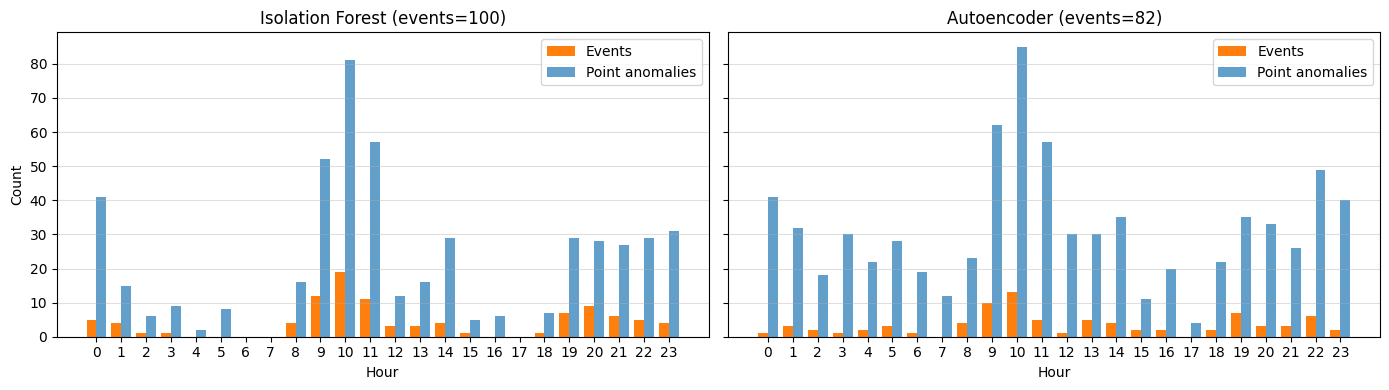

In [162]:
# ============================================================
# ============ DISTRIBUTIONS & PLOTTING ======================
# ============================================================

# --- Calculate point anomaly distributions (per hour) ---
if len(iso_mask_hyst) > 0:
    point_iso = pd.Series(iso_mask_hyst, index=iso_mask_hyst.index)
    point_iso_hours = point_iso[point_iso].index.hour
    dist_iso_points = pd.Series(point_iso_hours).value_counts().sort_index().reindex(range(24), fill_value=0)
else:
    dist_iso_points = pd.Series([0]*24, index=range(24))

if len(ae_mask_hyst) > 0:
    point_ae = pd.Series(ae_mask_hyst, index=ae_mask_hyst.index)
    point_ae_hours = point_ae[point_ae].index.hour
    dist_ae_points = pd.Series(point_ae_hours).value_counts().sort_index().reindex(range(24), fill_value=0)
else:
    dist_ae_points = pd.Series([0]*24, index=range(24))

# --- Existing event distributions ---
if len(iso_events) > 0:
    dist_iso = (iso_events["start"].dt.hour.value_counts().sort_index()
                .reindex(range(24), fill_value=0))
else:
    dist_iso = pd.Series([0]*24, index=range(24))

if len(ae_events) > 0:
    dist_ae = (ae_events["start"].dt.hour.value_counts().sort_index()
               .reindex(range(24), fill_value=0))
else:
    dist_ae = pd.Series([0]*24, index=range(24))

import numpy as np

# --- Plot grouped barplots for events and point anomalies ---
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, sharey=True)

width = 0.4
x = np.arange(24)

# Isolation Forest
axes[0].bar(x - width/2, dist_iso.values, width=width, label="Events", color="tab:orange")
axes[0].bar(x + width/2, dist_iso_points.values, width=width, label="Point anomalies", color="tab:blue", alpha=0.7)
axes[0].set_title(f"Isolation Forest (events={iso_event_count})")
axes[0].set_xlabel("Hour")
axes[0].set_ylabel("Count")
axes[0].set_xticks(x)
axes[0].legend()
axes[0].grid(True, which='both', axis='y', alpha=0.4)

# Autoencoder
axes[1].bar(x - width/2, dist_ae.values, width=width, label="Events", color="tab:orange")
axes[1].bar(x + width/2, dist_ae_points.values, width=width, label="Point anomalies", color="tab:blue", alpha=0.7)
axes[1].set_title(f"Autoencoder (events={ae_event_count})")
axes[1].set_xlabel("Hour")
axes[1].set_ylabel("")
axes[1].set_xticks(x)
axes[1].legend()
axes[1].grid(True, which='both', axis='y', alpha=0.4)

plt.tight_layout()
plt.show()

The two panels summarize the distribution of detections from the Isolation Forest and Autoencoder pipelines and reveal a consistent behavioral rhythm in the data. Both methods produce concentration of detections in the late morning (roughly 09:00–12:00), with maxima around 10–11 h, and smaller secondary peaks in the evening period (about 19:00–22:00), while the early night and pre-dawn hours show comparatively few detections. This pattern is plausible for residential settings: morning peaks align with post-wakeup routines (airing after overnight accumulation, bathroom and kitchen use, cleaning) and large indoor-outdoor temperature gradients, whereas evening peaks are consistent with return-home and pre-sleep ventilation habits. The blue bars (point anomalies) substantially outnumber the orange bars (events) in each hour, indicating that anomalies cluster temporally and that the post-processing is effectively consolidating many closely spaced outlier points into a smaller number of physically interpretable episodes. 

The Isolation Forest yields more events overall (100 vs. 82) and a slightly broader shoulder around the morning maximum, suggesting it is marginally more sensitive to short, noisy excursions than the autoencoder, whereas the autoencoder's distribution is somewhat sparser but preserves the same peak hours. Overall, despite methodological differences, both detectors agree on a clear pattern, leading to the interpretation that window-opening or ventilation-like behavior is most frequent in late morning with a secondary evening tendency.

Given that we are using unsupervised ML methods, without a ground truth data, the weak validation has been done in interviewing the occupants, where the detected pattern has been confirmed. 

[Joint IF∩AE] events: 46
[Joint IF∩AE] point anomalies: 303


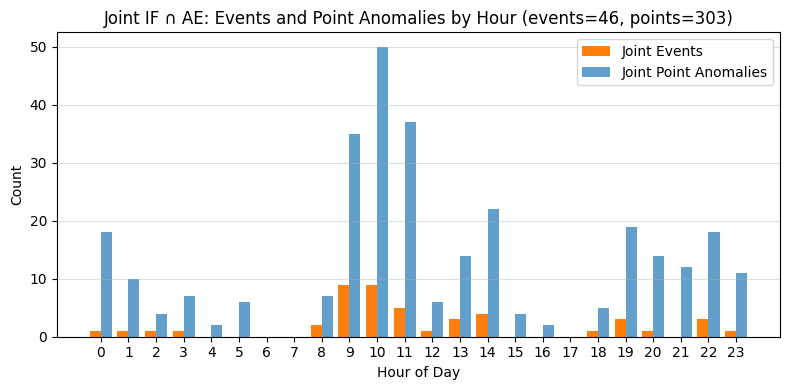

In [164]:
# Defaults if not defined earlier
try:
    MIN_DURATION_SAMPLES
except NameError:
    MIN_DURATION_SAMPLES = 2   # e.g., ≥ 6 min at 3-min sampling
try:
    SAMPLING_MIN
except NameError:
    SAMPLING_MIN = 3           # minutes per sample

# 1) Build joint (IF ∩ AE) anomaly mask on common index
common_idx = iso_mask_hyst.index.intersection(ae_mask_hyst.index)
m_if = iso_mask_hyst.reindex(common_idx).fillna(False).astype(bool)
m_ae = ae_mask_hyst.reindex(common_idx).fillna(False).astype(bool)
joint_mask = m_if & m_ae

# 2) Group into joint events with min duration
starts = joint_mask & (~joint_mask.shift(1, fill_value=False))
event_id = starts.cumsum().where(joint_mask, np.nan)

joint_events = []
s = pd.Series(joint_mask, index=common_idx)
for eid, g in s[s].groupby(event_id):
    idxs = g.index
    dur_samples = len(idxs)
    if dur_samples < MIN_DURATION_SAMPLES:
        continue
    joint_events.append({
        "event_id": int(eid),
        "start": idxs[0],
        "end": idxs[-1],
        "duration_min": dur_samples * SAMPLING_MIN
    })
joint_events = pd.DataFrame(joint_events)

# 3) Count & hour-of-day distribution for events
n_joint = len(joint_events)
print(f"[Joint IF∩AE] events: {n_joint}")

hour_counts_events = (joint_events["start"].dt.hour.value_counts()
               .sort_index()
               .reindex(range(24), fill_value=0))

# 4) Joint point anomalies (not grouped into events, just all True in joint_mask)
joint_point_count = int(joint_mask.sum())
print(f"[Joint IF∩AE] point anomalies: {joint_point_count}")

joint_point_hours = pd.Series(joint_mask[joint_mask].index.hour)
hour_counts_points = joint_point_hours.value_counts().sort_index().reindex(range(24), fill_value=0)

# 5) Grouped bar plot for both
import numpy as np
plt.figure(figsize=(8,4))
width = 0.4
x = np.arange(24)
plt.bar(x - width/2, hour_counts_events.values, width=width, label="Joint Events", color="tab:orange")
plt.bar(x + width/2, hour_counts_points.values, width=width, label="Joint Point Anomalies", color="tab:blue", alpha=0.7)
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.title(f"Joint IF ∩ AE: Events and Point Anomalies by Hour (events={n_joint}, points={joint_point_count})")
plt.xticks(x)
plt.legend()
plt.grid(True, which='both', axis='y', alpha=0.4)
plt.tight_layout()
plt.show()


The joint histogram (IF ∩ AE) summarizes where the two detectors agree, and it shows that their consensus concentrates in late morning (≈09–12 h) with a smaller evening band (≈19–22 h), while both methods largely abstain overnight. Requiring agreement collapses 303 jointly flagged points into 46 events. The distribution mirrors what each method showed individually, so the diurnal structure is method-robust rather than an artifact of a single scoring rule. Since the intersection trades recall for precision, these consensus events can be interpreted as the most reliable ventilation candidates: they survive differences in modeling assumptions (tree-based isolation vs. reconstruction error). Residual peaks that disappear in the joint view likely reflected method-specific sensitivity or thresholding issues.

In [158]:
import numpy as np
import pandas as pd

# Case A: you already built iso_events (with a "start" column)
if 'iso_events' in globals() and isinstance(iso_events, pd.DataFrame) and not iso_events.empty:
    start_times = pd.to_datetime(iso_events['start']).sort_values().to_numpy()
    start_ilocs = df_features_r4.index.get_indexer(start_times)  # integer positions
    # Print & keep as arrays
    for iloc, ts in zip(start_ilocs, start_times):
        print(f"start_iloc={iloc:>7d}   start_time={ts}")
    event_start_ilocs = start_ilocs
    event_start_times = start_times

# Case B: derive starts directly from the refined anomaly mask
else:
    # Prefer refined mask; fall back to raw IF preds if needed
    if 'iso_mask_hyst' in globals():
        mask = iso_mask_hyst.astype(bool).reindex(df_features_r4.index).fillna(False)
    else:
        # If you only have fitted IF and scaled features:
        pred = iso.predict(X_scaled)  # -1 = anomaly, +1 = normal
        mask = pd.Series(pred == -1, index=aligned_idx).reindex(df_features_r4.index).fillna(False)

    starts_bool = mask & (~mask.shift(1, fill_value=False))
    event_start_ilocs = np.flatnonzero(starts_bool.values)
    event_start_times = df_features_r4.index[event_start_ilocs]

    for iloc, ts in zip(event_start_ilocs, event_start_times):
        print(f"start_iloc={iloc:>7d}   start_time={ts}")

# Optional: put in a DataFrame (easy to export/filter)
event_starts_df = pd.DataFrame({
    "start_iloc": event_start_ilocs,
    "start_time": event_start_times
}).sort_values("start_iloc")

# display(event_starts_df.head(20))  # uncomment in notebooks


start_iloc=     95   start_time=2024-11-17T10:54:00.000000000
start_iloc=    415   start_time=2024-11-18T02:54:00.000000000
start_iloc=   1323   start_time=2024-11-20T00:18:00.000000000
start_iloc=   1497   start_time=2024-11-20T09:00:00.000000000
start_iloc=   2198   start_time=2024-11-21T20:03:00.000000000
start_iloc=   3138   start_time=2024-11-23T19:03:00.000000000
start_iloc=   3422   start_time=2024-11-24T09:15:00.000000000
start_iloc=   3452   start_time=2024-11-24T10:45:00.000000000
start_iloc=   3543   start_time=2024-11-24T15:18:00.000000000
start_iloc=   3934   start_time=2024-11-25T10:51:00.000000000
start_iloc=   4386   start_time=2024-11-26T09:27:00.000000000
start_iloc=   4417   start_time=2024-11-26T11:00:00.000000000
start_iloc=   4448   start_time=2024-11-26T12:33:00.000000000
start_iloc=   4715   start_time=2024-11-27T01:54:00.000000000
start_iloc=   4904   start_time=2024-11-27T11:21:00.000000000
start_iloc=   5161   start_time=2024-11-28T00:12:00.000000000
start_il

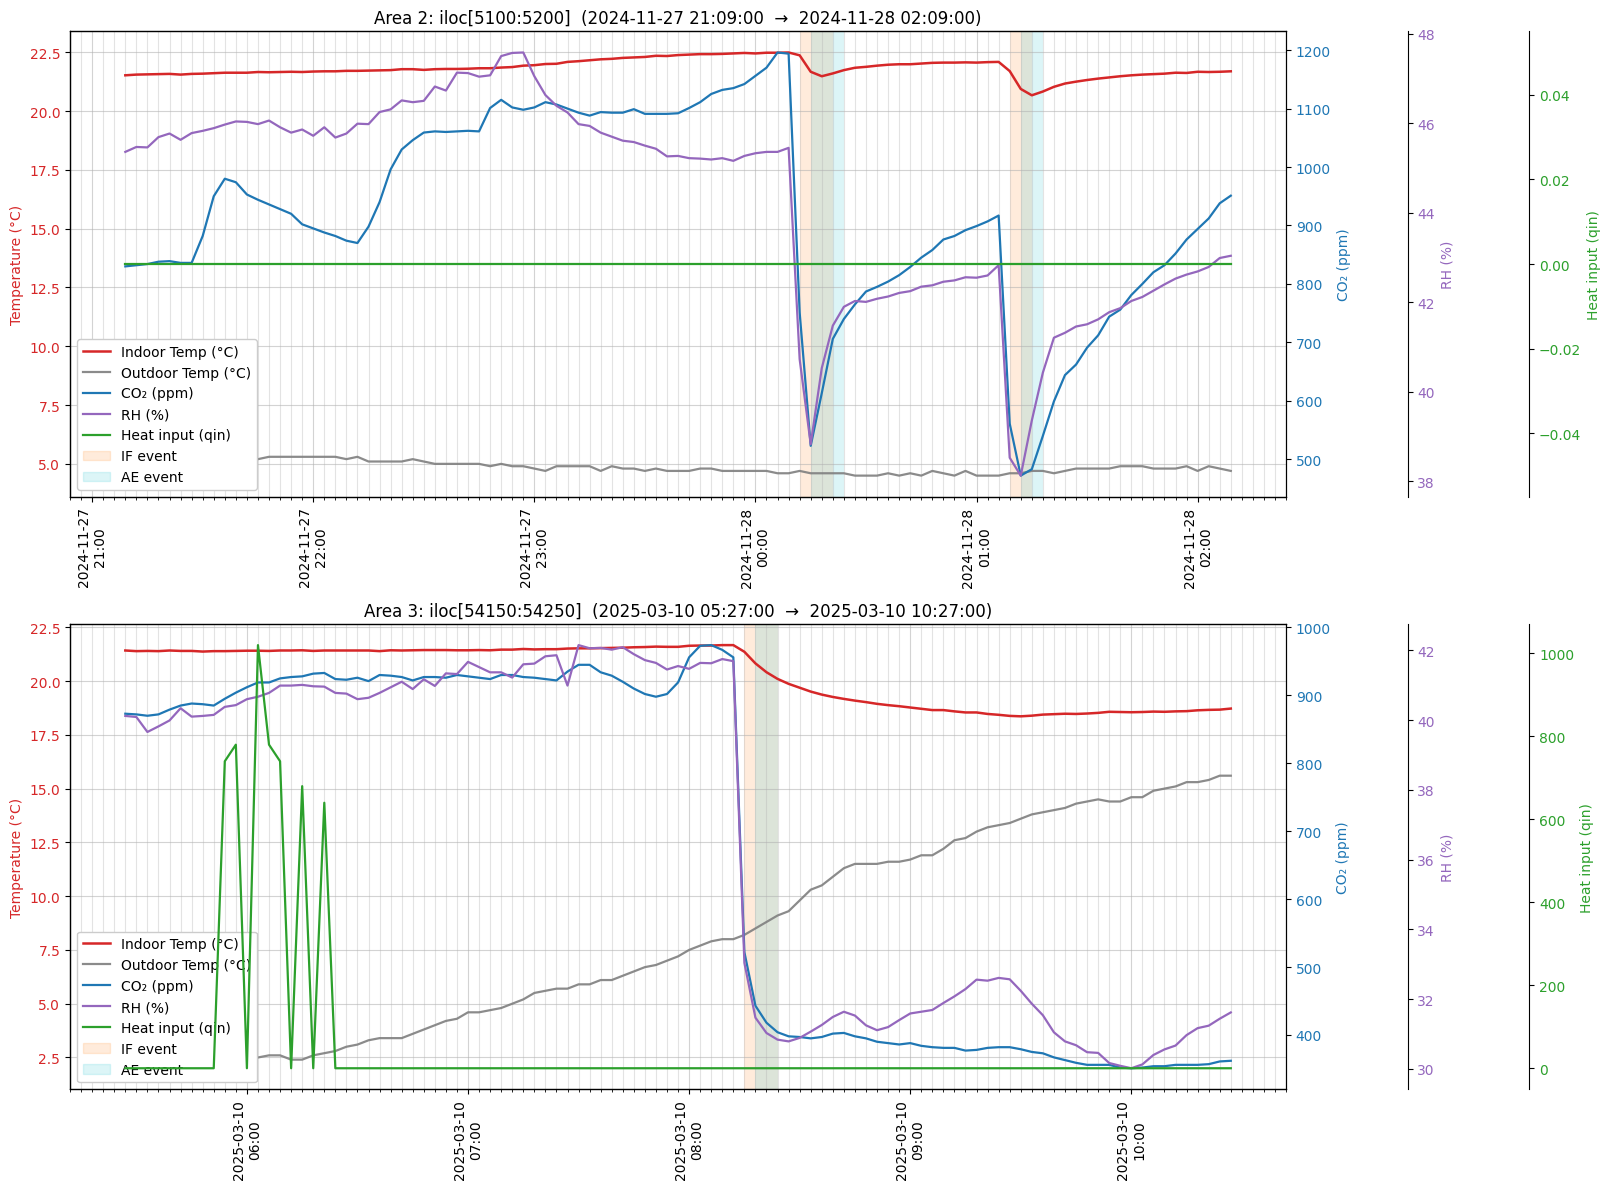

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator

# ================== PARAMETERS (edit these) ==================
area2_start, area2_end = 5100, 5200        # upper plot
#area2_start, area2_end = 7900, 8100        # upper plot
area3_start, area3_end = 54150, 54250      # lower plot

SHOW_ISO_EVENTS = True
SHOW_AE_EVENTS  = True

# Column names
TEMP_COL = "rtemp_4"
TAMB_COL = "t_amb"
CO2_COL  = "rco2_4"
HUM_COL  = "rhumid_4"
QIN_COL  = "qin"

# Labels
TEMP_LABEL = "Indoor Temp (°C)"
TAMB_LABEL = "Outdoor Temp (°C)"
CO2_LABEL  = "CO₂ (ppm)"
HUM_LABEL  = "RH (%)"
QIN_LABEL  = "Heat input (qin)"

# Colors
TEMP_COLOR = "tab:red"
TAMB_COLOR = "tab:gray"
CO2_COLOR  = "tab:blue"
HUM_COLOR  = "tab:purple"
QIN_COLOR  = "tab:green"

# Event shading
ISO_SHADE_COLOR = "tab:orange"
AE_SHADE_COLOR  = "tab:cyan"
SHADE_ALPHA     = 0.15
# ============================================================

df = df_features_r4.copy()

# Fallback to empty event frames if they don't exist
if 'iso_events' not in globals() or iso_events is None:
    iso_events = pd.DataFrame(columns=["start","end","duration_min"])
if 'ae_events' not in globals() or ae_events is None:
    ae_events = pd.DataFrame(columns=["start","end","duration_min"])

def _slice_by_iloc(df, i0, i1):
    n = len(df)
    i0 = max(0, min(int(i0), n-1))
    i1 = max(0, min(int(i1), n-1))
    if i1 < i0:
        i0, i1 = i1, i0
    return df.iloc[i0:i1+1], i0, i1  # end inclusive

# Only Area 2 (top) and Area 3 (bottom)
areas = [
    ("Area 2", area2_start, area2_end),
    ("Area 3", area3_start, area3_end),
]

fig, axes = plt.subplots(2, 1, figsize=(16, 12), sharex=False)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])
fig.subplots_adjust(right=0.82, hspace=0.3)

for ax, (title, i0, i1) in zip(axes, areas):
    win, i0c, i1c = _slice_by_iloc(df, i0, i1)
    if win.empty:
        ax.set_title(f"{title} (empty slice)")
        ax.axis("off")
        continue

    handles, labels = [], []

    # ===== Primary axis: rtemp_4 + t_amb =====
    if TEMP_COL in win:
        h_temp, = ax.plot(win.index, win[TEMP_COL], lw=1.8, color=TEMP_COLOR, label=TEMP_LABEL)
        handles.append(h_temp); labels.append(TEMP_LABEL)
        ax.set_ylabel("Temperature (°C)", color=TEMP_COLOR)
        ax.tick_params(axis='y', labelcolor=TEMP_COLOR)

    if TAMB_COL in win:
        h_tamb, = ax.plot(win.index, win[TAMB_COL], lw=1.6, color=TAMB_COLOR, alpha=0.9, label=TAMB_LABEL)
        handles.append(h_tamb); labels.append(TAMB_LABEL)

    # ===== Secondary axes: CO2, RH, qin =====
    sec_specs = []
    if CO2_COL in win:
        ax_co2 = ax.twinx();      sec_specs.append((ax_co2, CO2_COLOR, CO2_LABEL, win[CO2_COL]))
    if HUM_COL in win:
        ax_hum = ax.twinx();      sec_specs.append((ax_hum, HUM_COLOR, HUM_LABEL, win[HUM_COL]))
    if QIN_COL in win:
        ax_qin = ax.twinx();      sec_specs.append((ax_qin, QIN_COLOR, QIN_LABEL, win[QIN_COL]))

    for k, (axr, color, ylab, series) in enumerate(sec_specs):
        if k >= 1:
            axr.spines["right"].set_position(("axes", 1.0 + 0.1 * k))
            axr.set_frame_on(True)
        # optional:
        # axr.patch.set_visible(False)
        # axr.set_zorder(0.5); ax.set_zorder(1)

        h_line, = axr.plot(win.index, series, lw=1.6, color=color, label=ylab)
        axr.set_ylabel(ylab, color=color)
        axr.tick_params(axis='y', labelcolor=color)
        handles.append(h_line); labels.append(ylab)

    # ===== Event shading (IF + AE) =====
    patches = []
    tmin, tmax = win.index[0], win.index[-1]

    if SHOW_ISO_EVENTS and not iso_events.empty:
        had_iso = False
        for _, ev in iso_events.iterrows():
            s, e = ev["start"], ev["end"]
            if (e >= tmin) and (s <= tmax):
                ax.axvspan(max(s, tmin), min(e, tmax), color=ISO_SHADE_COLOR, alpha=SHADE_ALPHA, linewidth=0)
                had_iso = True
        if had_iso:
            patches.append(mpatches.Patch(color=ISO_SHADE_COLOR, alpha=SHADE_ALPHA, label="IF event"))

    if SHOW_AE_EVENTS and not ae_events.empty:
        had_ae = False
        for _, ev in ae_events.iterrows():
            s, e = ev["start"], ev["end"]
            if (e >= tmin) and (s <= tmax):
                ax.axvspan(max(s, tmin), min(e, tmax), color=AE_SHADE_COLOR, alpha=SHADE_ALPHA, linewidth=0)
                had_ae = True
        if had_ae:
            patches.append(mpatches.Patch(color=AE_SHADE_COLOR, alpha=SHADE_ALPHA, label="AE event"))

    # ===== Legend & cosmetics =====
    handles += patches
    labels  += [p.get_label() for p in patches]
    if handles:
        leg = ax.legend(handles, labels, loc="lower left", frameon=True)
        leg.get_frame().set_facecolor("white")
        leg.get_frame().set_alpha(1.0)
        leg.set_zorder(5)

    ax.set_title(f"{title}: iloc[{i0c}:{i1c}]  ({win.index[0]}  →  {win.index[-1]})")
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=3))
    ax.yaxis.set_minor_locator(MultipleLocator(2.5))

    ax.grid(True, which='major', axis='both', alpha=0.55)
    ax.grid(True, which='minor', axis='both', alpha=0.35)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax.tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.show()


# Conclusions

The results presented in this paper demonstrate that window-opening behavior in district-heated apartments can be reliably inferred from standard telemetry, including indoor temperature, CO₂, relative humidity, outdoor temperature, and heating context, when these signals are transformed into physically motivated features and analyzed with unsupervised multivariate detectors. 

Using 3-minute resolution data across a full heating season, Isolation Forest and a bottleneck Autoencoder each identified coherent clusters of short-horizon anomalies that, after method-agnostic post-processing (gap-bridging, hysteresis, minimum duration, and a joint cooling-dilution onset check), condensed into interpretable ventilation events. Quantitatively, Isolation Forest yielded 506 point anomalies consolidated into 100 events, while the Autoencoder produced 764 points and 82 events; their intersection preserved the same temporal structure while emphasizing precision (46 consensus events formed from 303 jointly flagged points). Both detectors produced a consistent diurnal signature: a dominant late-morning concentration with a smaller evening band, and very few detections overnight.

These findings indicate that: 1. the engineered features capture the physics of rapid heat loss, dilution, and short-term variability accompanying natural ventilation; 2. the main conclusions are robust to modeling choice (tree-based isolation vs. reconstruction error); and 3. unsupervised methods, even without dedicated instrumentation or ground truth labels, can uncover patterns of occupant ventilation that matter for demand-aware operation of district heating.

Several limitations point to concrete directions for future work. While the initial results can be confirmed at the distribution level, for the final model, external validation is needed. Synchronized ground-truth sensing would calibrate thresholds, quantify precision/recall, and bound uncertainty. Second, regime-aware, adaptable scoring and thresholds (e.g., hour-of-day, weather class, or occupancy-proxy stratification) could help highlighting the intrinsic diurnal variability and reduce detector bias. Third, expanding from single-apartment analysis to multi-apartment, multi-season cohorts will support transfer learning and robustness checks across buildings, emitters, and climates. Finally, integrating the pipeline into real-time operations would enable demand-aware setpoint scheduling and targeted advisory to occupants, with prospective evaluation of comfort and energy impacts. By addressing these steps, the approach can evolve from retrospective analytics to a validated, interpretable, and deployable component of intelligent district-heating control.

# References

Aminikhanghahi, S., Wang, T., & Cook, D. J. (2019). Real-time change point detection with application to smart home time series data. IEEE Transactions on Knowledge and Data Engineering, 31(5), 1010–1023. https://doi.org/10.1109/TKDE.2018.2850347

Andersen, R., Fabi, V., Toftum, J., Corgnati, S. P., & Olesen, B. W. (2013). Window opening behaviour modelled from measurements in Danish dwellings. Building and Environment, 69, 101–113. https://doi.org/10.1016/J.BUILDENV.2013.07.005

Barthelmes, V. M., Heo, Y., Fabi, V., & Corgnati, S. P. (2017). Exploration of the Bayesian Network framework for modelling window control behaviour. Building and Environment, 126, 318–330. https://doi.org/10.1016/J.BUILDENV.2017.10.011

de Rautlin de la Roy, E., Recht, T., Zemmari, A., Bourreau, P., & Mora, L. (2023). Deep learning models for building window-openings detection in heating season. Building and Environment, 231, 110019. https://doi.org/10.1016/J.BUILDENV.2023.110019

Jiang, C., Pannier, M.-L., Godon, A., & Bigaud, D. (2022). Comparison of building occupants activities detection methods using simulated data: a case of window opening detection. 255. https://doi.org/10.34894/VQ1DJA

Liu, Y., Chong, W. T., Yau, Y. H., Han, D., Qin, M., Deng, F., Wang, X., & Pan, S. (2023). A new algorithm for real-time detection of window opening area in residential buildings. Building and Environment, 244, 110817. https://doi.org/10.1016/J.BUILDENV.2023.110817

Liu, Y., Chong, W. T., Yau, Y. H., Wu, J., Chang, Y., Cui, T., Chang, L., & Pan, S. (2024). A hybrid learning approach to model the diversity of window-opening behavior. Building and Environment, 257, 111525. https://doi.org/10.1016/J.BUILDENV.2024.111525

Mo, H., Sun, H., Liu, J., & Wei, S. (2019). Developing window behavior models for residential buildings using XGBoost algorithm. Energy and Buildings, 205, 109564. https://doi.org/10.1016/J.ENBUILD.2019.109564

Park, J., Jeong, B., Chae, Y. T., & Jeong, J. W. (2021). Machine learning algorithms for predicting occupants’ behaviour in the manual control of windows for cross-ventilation in homes. Indoor and Built Environment, 30(8), 1106–1123. https://doi.org/10.1177/1420326X20927070;PAGE:STRING:ARTICLE/CHAPTER

Pereira, P. F., & Ramos, N. M. M. (2018). Detection of occupant actions in buildings through change point analysis of in-situ measurements. Energy and Buildings, 173, 365–377. https://doi.org/10.1016/J.ENBUILD.2018.05.050

Pereira, P. F., Ramos, N. M. M., Almeida, R. M. S. F., & Simões, M. L. (2018). Methodology for detection of occupant actions in residential buildings using indoor environment monitoring systems. Building and Environment, 146, 107–118. https://doi.org/10.1016/J.BUILDENV.2018.09.047

Sezen, G., Cakir, M., Atik, M. E., & Duran, Z. (2022). DEEP LEARNING-BASED DOOR AND WINDOW DETECTION FROM BUILDING FAÇADE. International Archives of the Photogrammetry, Remote Sensing and Spatial Information Sciences - ISPRS Archives, 43(B4-2022), 315–320. https://doi.org/10.5194/ISPRS-ARCHIVES-XLIII-B4-2022-315-2022,

Sun, C., Guo, X., Zhao, T., & Han, Y. (2022). Real-time detection method of window opening behavior using deep learning-based image recognition in severe cold regions. Energy and Buildings, 268, 112196. https://doi.org/10.1016/J.ENBUILD.2022.112196

Tien, P. W., Wei, S., Calautit, J. K., Darkwa, J., & Wood, C. (2022). Enhancing the detection performance of a vision-based window opening detector. Cleaner Energy Systems, 3, 100038. https://doi.org/10.1016/J.CLES.2022.100038

Ume-Ezeoke, J. N., Nihar, K., Gorle, C., & Jain, R. (2024). Towards a data-driven and scalable approach for window operation detection in multi-family residential buildings. Proceedings Of, 1.

Yao, M., & Zhao, B. (2017). Window opening behavior of occupants in residential buildings in Beijing. Building and Environment, 124, 441–449. https://doi.org/10.1016/J.BUILDENV.2017.08.035

Cvetković, S., Zdravković, M., & Ignjatović, M. (2025). Exploring district heating systems: A SCADA dataset for enhanced explainability. Data in Brief, 59, 111320. https://doi.org/10.1016/j.dib.2025.111320

Turudija, R., Stojiljković, D., Zdravković, M., & Ignjatović, M. (2024). Towards an Approach to Multivariate Outlier Detection for District Heating System Data. In M. Trajanović, N. Filipović, & M. Zdravković (Eds.), Disruptive Information Technologies for a Smart Society (Vol. 860, pp. 49–61). Springer Nature Switzerland. https://doi.org/10.1007/978-3-031-71419-1_5

Zdravković, M., Ćirić, I., & Ignjatović, M. (2022). Explainable heat demand forecasting for the novel control strategies of district heating systems. Annual Reviews in Control, 53, 405–413. https://doi.org/10.1016/j.arcontrol.2022.03.009

Zdravković, M., Cvetković, S., Ignjatović, M., Ćirić, I., Mitrović, D., Stojiljković, M., Nejković, V., Stojiljković, D., & Turudija, R. (2024). XAI4HEAT: Towards Demand-Driven, AI Facilitated Management of District Heating Systems. In M. Trajanović, N. Filipović, & M. Zdravković (Eds.), Disruptive Information Technologies for a Smart Society (Vol. 860, pp. 23–34). Springer Nature Switzerland. https://doi.org/10.1007/978-3-031-71419-1_3